In [39]:
# IMPORT
%matplotlib inline
import csv
import os
from operator import itemgetter, attrgetter, methodcaller
from skimage.filters import threshold_otsu, threshold_adaptive, rank
from skimage.morphology import disk
from skimage.feature import match_template
from skimage.color import lab2rgb
from skimage.io import imread as sk_imread
import matplotlib.image as img
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from PIL import ImageDraw, ImageFont
import PIL.Image as PILImage
from scipy import ndimage

import ipywidgets as widgets
from IPython.display import Image
from IPython import display

# Imports the Google Cloud client library
from google.cloud import storage

In [35]:
# UTILITY func
CUBE_SIZE = 250
EDGE_GAP = 50
HORIZ_TOLERANCE_FACTOR = 50
VERT_TOLERANCE_FACTOR = 75
cube_size = 250
less_than_half_cube = 122
minikube_size = cube_size - (less_than_half_cube * 2)

bucket_name = "thesis-papyri"
imgs_root = "PAPYRI/" # "/Volumes/250GB/PAPYRI/"
cropped_root = "/cropped2/" # "/Volumes/250gb/cropped2"
matched_root = "/matched593/" # "/Volumes/250gb/cropped2"
local_temp_root = "/Users/il239838/Downloads/temp/"

# Instantiates a client
storage_client = storage.Client()

def list_blobs_with_prefix(prefix):
    bucket = storage_client.get_bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix, delimiter='/')

    for blob in blobs:
        if blob.name[-1] != '/':
            yield blob.name
        
    #     if delimiter:
    #         print('Prefixes:')
    #         for prefix in blobs.prefixes:
    #             print(prefix)

def download_blob(source_blob_name, destination_file_name):
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(source_blob_name)

    blob.download_to_filename(destination_file_name)

    print('Blob {} downloaded to {}.'.format(
        source_blob_name,
        destination_file_name))

def gcp_img_read(img_path):
    # import pdb; pdb.set_trace()
    fname = img_path[img_path.rfind("/") + 1:]
    download_blob(img_path, local_temp_root + fname)
    result = img.imread(local_temp_root + fname)
    os.remove(local_temp_root + fname)
    return result

def gcp_np_load(img_path):
    # import pdb; pdb.set_trace()
    fname = img_path[img_path.rfind("/") + 1:]
    download_blob(img_path, local_temp_root + fname)
    result = np.load(local_temp_root + fname)
    os.remove(local_temp_root + fname)
    return result
    
# Simple crop by x/y ranges
def crop(image, ymin, ymax, xmin, xmax):
    return image[ymin:ymax, xmin:xmax]


def calc_combined_coordinates(base_x, base_y, offset_x, offset_y, base_rotate, base_x_end):
    if base_rotate:
        result_x = base_x_end - cube_size - offset_y # 250==CUBE_SIZE
        result_y = base_y + offset_x
    else:
        result_x = base_x + offset_x
        result_y = base_y + offset_y
    return result_x, result_y

def load_img_for_name(file_name):
    img_path = ""
    if "-" in file_name:
        name_parts = file_name.split("-")
        unique_part = name_parts[0] + "-" + name_parts[1] + "-" + name_parts[2]
        img_path = imgs_root + name_parts[0] + "/" + \
            unique_part + "/"
    else:
        img_path = imgs_root + file_name[0:4] + "/" + \
            file_name[0:4] + "-" + file_name[4:9] + "-V/"
    
    for file_ in list_blobs_with_prefix(img_path):
        if (" _018" in file_):        
            return gcp_img_read(file_) # img.imread(img_path + file_)

def load_cropped_for_name(file_name):
    img_path = cropped_root + "/" + file_name + " _018.jpg.npy"
    return gcp_np_load(img_path) # np.load(img_path)

def load_front_for_name(file_name):
    img_path = ""
    if "-" in file_name:
        front_file_name = file_name.replace("-V-","-R-")
        name_parts = front_file_name.split("-")
        unique_part = name_parts[0] + "-" + name_parts[1] + "-" + name_parts[2]
        img_path = imgs_root + name_parts[0] + "/" + \
            unique_part + "/"
    else:
        img_path = imgs_root + file_name[0:4] + "/" + \
            file_name[0:4] + "-" + file_name[4:9] + "-R/"
    #import pdb; pdb.set_trace()
    #for root, dirs, files in os.walk(img_path):
    for file_ in list_blobs_with_prefix(img_path):
        if (" _018" in file_):        
            return gcp_img_read(file_) # img.imread(img_path + file_)
    
# Pre-process the validation set
def folder_walker(path, full_path, filter_text=""):
    result = []
    #for root, dirs, files in os.walk(img_path):
    for file_ in list_blobs_with_prefix(path):
        if "-V-" in file_ and not file_.startswith("."):
            if (filter_text == "" or filter_text in file_):
                result.append(file_)
    return result

no_rotate_raw = folder_walker("no_rotate/", False)
no_rotate = []
for file_ in no_rotate_raw:
    file_ = file_[file_.rfind('/')+1:]
    split = file_.split("-")
    no_rotate.append(split[0]+split[1])

In [57]:
# UTIL 2
def find_match(big_img, small_img):
    match_map = match_template(big_img, small_img)
    offsets_arr = np.unravel_index(np.argmax(match_map), match_map.shape)
    offset_x, offset_y = offsets_arr[::-1]        
    return offset_x, offset_y, match_map[offsets_arr]
  

def extract_image_derivatives(file_name):
    image = load_img_for_name(file_name)
    split = file_name.split("-")
    short_name = split[0] + split[1]
    img_crop = crops[short_name]
    cropped = crop(image, img_crop['y_start']-cube_size, img_crop['y_end']+cube_size, \
                   img_crop['x_start']-cube_size, img_crop['x_end']+cube_size)
    front = load_front_for_name(file_name)
    front_adaptive = threshold_adaptive(front, 251, offset=5)  
    # import pdb; pdb.set_trace()
    cropped_adaptive = threshold_adaptive(cropped, 251, offset=5)
    cropped_flipped_lr = cropped_adaptive[:,::-1]
    offset_x_lr, offset_y_lr, val_lr = find_match(front_adaptive, cropped_flipped_lr)
    cropped_flipped_ud = cropped_adaptive[:,::-1]
    offset_x_ud, offset_y_ud, val_ud = find_match(front_adaptive, cropped_flipped_ud)

    if (val_lr > val_ud):
        return cropped_flipped_lr.shape[1], offset_x_lr, offset_y_lr
    else:
        return cropped_flipped_ud.shape[1], offset_x_ud, offset_y_ud
    

def extract_image_derivatives_orig(file_name):
    image = load_img_for_name(file_name)
    split = file_name.split("-")
    short_name = split[0] + split[1]
    img_crop = crops[short_name]
    cropped = crop(image, img_crop['y_start']-cube_size, img_crop['y_end']+cube_size, \
                   img_crop['x_start']-cube_size, img_crop['x_end']+cube_size)
    front = load_front_for_name(file_name)
    front_adaptive = threshold_adaptive(front, 251, offset=5)  
    
    cropped_adaptive = threshold_adaptive(cropped, 251, offset=5)
    cropped_flipped_lr = cropped_adaptive[:,::-1]
    offset_x_lr, offset_y_lr, val_lr = find_match(front_adaptive, cropped_flipped_lr)
    cropped_flipped_ud = cropped_adaptive[:,::-1]
    offset_x_ud, offset_y_ud, val_ud = find_match(front_adaptive, cropped_flipped_ud)

    if (val_lr > val_ud):
        return front, cropped_flipped_lr, offset_x_lr, offset_y_lr
    else:
        return front, cropped_flipped_ud, offset_x_ud, offset_y_ud
    
    


def get_cube_coordinates(file_name, cropped_width, offset_x, offset_y, horizontal_flip, cubex, cubey):
    #import pdb; pdb.set_trace()
    if file_name not in no_rotate:
        temp = cubex
        cubex = cropped_width - cubey - cube_size
        cubey = temp

    # Next block is correcting the fact that the match between verso and recto is done with some edge
    # on the verso fragment - so we add cube_size all sides - hence we have to reduce them here
    # when applying the coordinates of the cubes
    cropped_width -= (cube_size * 2)
    offset_x += cube_size
    offset_y += cube_size
    
    # The (-cube_size) is used in order to draw the cubes on the correct spot since the flipping
    # of the fragments essentially means that the start point of the drawing is backwards 
    # either on x-axis or on y-axis - depending on whether this is a horizontal flip or not
                    # (-cube_size if horizontal_flip else 0) + \
    reverse_cubex = -cube_size + \
        offset_x + cube_size + (cropped_width - cubex - cube_size)
                    # (-cube_size if not horizontal_flip else 0) + \
    reverse_cubey = -cube_size + \
        offset_y + cube_size + cubey
    
    return reverse_cubex, reverse_cubey, reverse_cubex - offset_x, reverse_cubey - offset_y

def get_cropped(image, file_name, cropped_width, offset_x, offset_y, horizontal_flip):
    img_crop = crops[file_name]
    img_width = img_crop['x_end'] - img_crop['x_start']
    img_height = img_crop['y_end'] - img_crop['y_start']
    cropped = crop(image, offset_y+cube_size, offset_y+img_height+cube_size, offset_x+cube_size, offset_x+img_width+cube_size)
    return cropped

def get_cropped_rudimentary(image, file_name):
    # import pdb; pdb.set_trace()
    short_name = file_name
    if "-" in file_name:
        short_name = file_name.split("-")
        short_name = short_name[0] + short_name[1]
    
    # We are using here the crop measurements of the back side in order to crop the front side - this is bad!!
    img_crop = crops[short_name]
    
    cropped = crop(image, img_crop['y_start']-cube_size, img_crop['y_end']+cube_size, \
                   img_crop['x_start']-cube_size, img_crop['x_end']+cube_size)
    return cropped


In [4]:
# READ crops
crops = {}
with open('crops.csv') as csvfile:
    reader = csv.DictReader(csvfile, fieldnames=("file","x_start","y_start","x_end","y_end","rotate"))
    next(reader)
    for row in reader:
        row['name'] = row['file'].split("/")[5] # stay with the folder name
        row['name'] = row['name'].split("-")
        row['name'] = row['name'][0] + row['name'][1] # set the short name...
        row['x_start'] = int(row['x_start'])
        row['y_start'] = int(row['y_start'])
        row['x_end'] = int(row['x_end'])
        row['y_end'] = int(row['y_end'])
        # import pdb; pdb.set_trace()
        row['rotate'] = True if row['rotate'] == 'True' else False
        crops[row['name']] = row


In [5]:
# READ matches
matches = {}
with open('20181020_212330_pairs_final_flipped.csv') as csvfile: # cubes_X3
    reader = csv.DictReader(csvfile, fieldnames=("fragmentAndSide", 
                        "fragment", 
                        "fragmentTotal",
                        "fragmentVote",
                        "devideVoteByTotal",
                        "fragmentAndSideTotal",
                        "fragmentAndSideVote",
                        "devideSideVoteBySideTotal",
                        "fragmentAndSideTrendVote",
                        "devideSideTrendVoteBySideTotal",
                        "fragmentAndSideTrendVoteStrict",
                        "devideSideTrendVoteStrictBySideTotal",
                        "fragmentAndSideTrendVoteSync",
                        "devideSideTrendVoteSyncBySideTotal",
                        "firstFileName",
                        "firstCroppedWidth",
                        "firstOffsetX",
                        "firstOffsetY",
                        "firstHorizontalFlip",
                        "secondFileName",
                        "secondCroppedWidth",
                        "secondOffsetX",
                        "secondOffsetY",
                        "secondHorizontalFlip",
                        "fragmentAndSideTrend",
                        "rotateFragmentAndSideCubes",
                        "rotateFragmentAndSideDrawRect",
                        "rotateFragmentAndSideMatchPoint",
                        "origCoordinates",
                        "class",
                        "votesOverlapMax",
                        "divideOverlapMaxBySideTotal",
                        "votesOverlapHeight",
                        "votesSupportOverlapRect",
                        "divideSupportOverlapBySideTotal",
                        "divideSupportOverlapBySideVote",
                        "fragmentAndSideCubes",
                        "fragmentAndSideDrawRect",
                        "fragmentAndSideMatchPoint"
                                                ))
    next(reader)
    for row in reader:
        matches[row["fragmentAndSide"]] = row

In [92]:
# Based on code from 18_alignment
def draw_match_front(df_row, firstImg, secondImg):
    rectanglesArr = eval(df_row["fragmentAndSideDrawRect"])
    if len(rectanglesArr) > 0:
        firstRotate = (df_row["fragmentAndSide"][df_row["fragmentAndSide"].rfind("P")-2] == "0")
        secondRotate = (df_row["fragmentAndSide"][-1] == "1")

        # rotate the images if needed
        if not firstRotate and df_row["firstHorizontalFlip"] == '1':
            firstImg = firstImg.rotate(180)
        if not secondRotate and df_row["secondHorizontalFlip"] == '1':
            secondImg = secondImg.rotate(180)

        cubesArr = eval(df_row["fragmentAndSideCubes"])
        pointsArr = eval(df_row["fragmentAndSideMatchPoint"])

        # correct the cubes, rects and points incase we had a rotation
        for cube, rect, point in zip(cubesArr, rectanglesArr, pointsArr):
            if not firstRotate:
                cube[0] = firstImg.shape[0] - cube[0] - cube_size # reduce cube_size cause we measure from top left corner of the cube
                cube[1] = firstImg.shape[1] - cube[1] - cube_size # reduce cube_size - see above
                rect[0] = cube[0] + cube_size + EDGE_GAP - HORIZ_TOLERANCE_FACTOR
                rect[2] = cube[0] + cube_size + EDGE_GAP + HORIZ_TOLERANCE_FACTOR
                point[0] = cube[0] + cube_size + EDGE_GAP
            if not secondRotate:
                cube[2] = secondImg.shape[0] - cube[2] - cube_size # reduce cube_size - see above
                cube[3] = secondImg.shape[1] - cube[3] - cube_size # reduce cube_size - see above
            if not firstRotate and not secondRotate:
                rect[1] = cube[1] - cube[3] - VERT_TOLERANCE_FACTOR
                rect[3] = cube[1] - cube[3] + VERT_TOLERANCE_FACTOR
                point[1] = cube[1] - cube[3]
                
        # rectanglesArr contains the projections of the matched position as they are reflected by each pair
        # In this block we set the size for the overlap slate
        mins = np.amin(rectanglesArr, 0)
        maxs = np.amax(rectanglesArr, 0)
        minsmaxs = [mins[0], mins[1], maxs[2], maxs[3]]
        minsmins = [mins[0], mins[1], mins[0], mins[1]]
        width = maxs[2] - mins[0]
        height = maxs[3] - mins[1]
        slate = np.zeros((width, height))

        # Now we iterate over the matched pair and add each match rectangle to the overlap count on the slate
        for rect in rectanglesArr:
            rect_slide = np.zeros((width, height))
            rect_adjusted =  np.subtract(rect, minsmins)
            rect_slide[rect_adjusted[0]:rect_adjusted[2], rect_adjusted[1]:rect_adjusted[3]] = 1
            slate = slate + rect_slide

        # Then we determine what's the max overlap that we observe and keep it and its size and derivative in the df
        # so we will use it later for the 2nd phase classification algorithm
        slate_max = np.amax(slate)
        max_indices = np.where(slate == slate_max)
    
        # Now we create a binary mask from the overlap max projection
        slate_mask = np.copy(slate)
        slate_mask[slate_mask < slate_max] = 0
        slate_mask[slate_mask == slate_max] = 1
        slate_mask_size = float(len(np.where(slate_mask == 1)[0]))

        # Calculate per each match pair what is the overlap of their projection with the mask of the max overlap
        overlaps_percent_arr = []
        for rect in rectanglesArr:
            rect_slide = np.zeros((width, height))
            rect_adjusted =  np.subtract(rect, minsmins)
            rect_slide[rect_adjusted[0]:rect_adjusted[2], rect_adjusted[1]:rect_adjusted[3]] = 1
            overlap_indices = np.where((rect_slide == slate_mask) & (rect_slide == 1))
            overlaps_percent_arr.append(float(len(overlap_indices[0]))/slate_mask_size)

        # We'll now use the mid-point of the max-overlap rectangle (based on the saved indices) in order to 
        # place and align the fragments
        # FIXME: need to fix next line as the square might be a jigsaw - need to pick the overall min and max indices
        voted_square = [max_indices[0][0], max_indices[1][0], max_indices[0][-1]+1, max_indices[1][-1]+1]
        adjusted_vote = np.add(minsmins,voted_square)
        mid_point = [(adjusted_vote[0] + adjusted_vote[2])/2, (adjusted_vote[1] + adjusted_vote[3])/2]
        
        # We prepare the measurements of the connected image
        # import pdb; pdb.set_trace()
        con_width = firstImg.shape[1] + secondImg.shape[1]
        con_height = 0
        first_offset = (-adjusted_vote[1]) if adjusted_vote[1] < 0 else 0
        second_offset = int(mid_point[1] + first_offset)
        adjusted_vote[1] += first_offset
        adjusted_vote[3] += first_offset
        con_height = int(np.maximum(firstImg.shape[0] + first_offset, secondImg.shape[0] + second_offset))

        # We paste the 2 images into the connected image in the correct offsets
        conImage = PILImage.new('RGBA', (con_width, con_height))
        conImage.paste(PILImage.fromarray(firstImg), (0, first_offset))
        conImage.paste(PILImage.fromarray(secondImg), (firstImg.shape[1]+1, second_offset))

        # Draw the image and draw the max overlap rectangle
        draw = ImageDraw.Draw(conImage)

        # Draw the lines from one image to the other based on the cubes
        cubeMid = CUBE_SIZE / 2
        for overlap_percent, cube_pair in zip(overlaps_percent_arr, cubesArr):
            color=""
            lwidth=1
            if (overlap_percent < 0.1):
                color="red"
            elif (overlap_percent < 0.5):
                color="yellow"
                lwidth=3
            else:
                color="green"
                lwidth=5
            #import pdb; pdb.set_trace()
            draw.line(((firstImg.shape[1] - cube_pair[0]) - cubeMid, \
                        cube_pair[1] + cubeMid + first_offset, \
                        firstImg.shape[1] + 1 + (secondImg.shape[1] - cube_pair[2]) - cubeMid, \
                        cube_pair[3] + cubeMid + second_offset), \
                      fill=color, width=lwidth)

        conImage.save(local_temp_root+str(df_row["class"])+"="+df_row["fragmentAndSide"]+".jpg")
        return conImage

In [102]:
# RUN
loading = img.imread("loading.jpg", format='jpg')
def view_image(item):
    # import pdb; pdb.set_trace()
    print("LOADING "+ item["firstFileName"])
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    plt.imshow(loading, cmap=plt.cm.gray)
    plt.show()

    plt.figure(figsize=(20, 20))
    gridspec.GridSpec(4,2)
    
    first = load_front_for_name(item["firstFileName"])
    second = load_front_for_name(item["secondFileName"])
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    ax1 = plt.subplot2grid((6, 2), (5,0))
    plt.axis('off')
    plt.imshow(first, cmap=plt.cm.gray)
    
    ax2 = plt.subplot2grid((6, 2), (5,1))
    plt.axis('off')
    plt.imshow(second, cmap=plt.cm.gray)

    first_cropped = get_cropped(first, item["firstFileName"], int(item["firstCroppedWidth"]), int(item["firstOffsetX"]), \
                                int(item["firstOffsetY"]), (True if item["firstHorizontalFlip"] == '1' else False))
    ax3 = plt.subplot2grid((6, 2), (3,0), rowspan=2)
    plt.axis('off')
    plt.imshow(first_cropped, cmap=plt.cm.gray)

    second_cropped = get_cropped(second, item["secondFileName"], int(item["secondCroppedWidth"]), int(item["secondOffsetX"]), \
                                 int(item["secondOffsetY"]), (True if item["secondHorizontalFlip"] == '1' else False))
    ax4 = plt.subplot2grid((6, 2), (3,1), rowspan=2)
    plt.axis('off')
    plt.imshow(second_cropped, cmap=plt.cm.gray)
    
    # draw the rectangles-centeres on the images
    for cube_match in eval(item["fragmentAndSideCubes"]):
        x_co, y_co, x_mini_co, y_mini_co = \
            get_cube_coordinates(item["firstFileName"], int(item["firstCroppedWidth"]), \
                                 int(item["firstOffsetX"]), int(item["firstOffsetY"]), \
                                 (True if item["firstHorizontalFlip"] == '1' else False), cube_match[0], cube_match[1])
        x_co += less_than_half_cube
        y_co += less_than_half_cube
        rect = plt.Rectangle((x_co, y_co), minikube_size, minikube_size, edgecolor='r', facecolor='r')
        ax1.add_patch(rect)    
        x_mini_co += less_than_half_cube
        y_mini_co += less_than_half_cube
        rect = plt.Rectangle((x_mini_co, y_mini_co), minikube_size, minikube_size, edgecolor='r', facecolor='r')
        ax3.add_patch(rect)    

        
        x_co, y_co, x_mini_co, y_mini_co = \
            get_cube_coordinates(item["secondFileName"], int(item["secondCroppedWidth"]), \
                                 int(item["secondOffsetX"]), int(item["secondOffsetY"]), \
                                 (True if item["secondHorizontalFlip"] == '1' else False), cube_match[2], cube_match[3])
        x_co += less_than_half_cube
        y_co += less_than_half_cube
        rect = plt.Rectangle((x_co, y_co), minikube_size, minikube_size, edgecolor='r', facecolor='r')
        ax2.add_patch(rect)    
        x_mini_co += less_than_half_cube
        y_mini_co += less_than_half_cube
        rect = plt.Rectangle((x_mini_co, y_mini_co), minikube_size, minikube_size, edgecolor='r', facecolor='r')
        ax4.add_patch(rect)    

    ax5 = plt.subplot2grid((6, 2), (0,0), colspan=2, rowspan=3)
    plt.axis('off')
    conn_front = draw_match_front(item, first_cropped, second_cropped)
    plt.imshow(conn_front, cmap=plt.cm.gray)

    plt.show()
    print("DONE "+ item["firstFileName"])


In [ ]:
widgets.interact(view_image, item=matches)

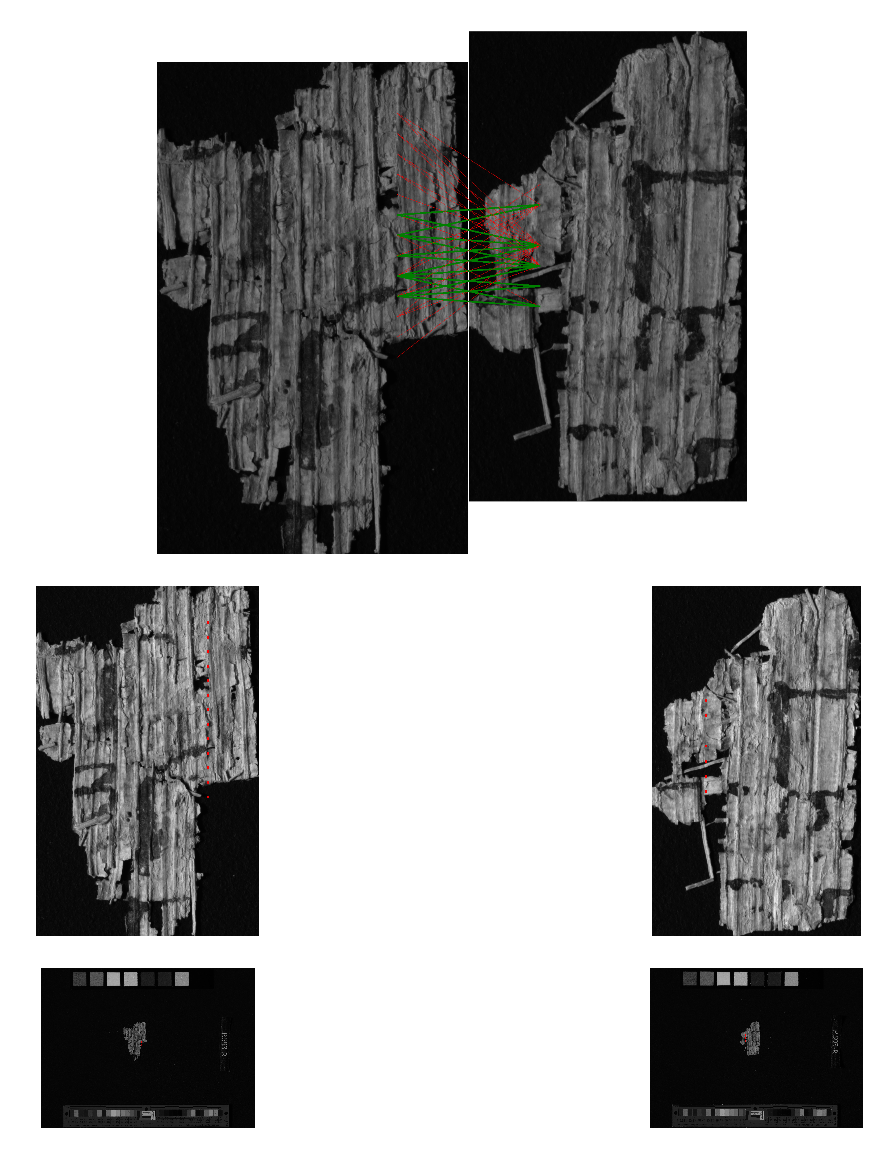

DONE P593Fg002


In [103]:
view_image(matches['P593Fg002_0_P593Fg015_1'])